### Csv. 장성민(6):

    - W2V feature -> DNN model: 과적합 심한 것을 지속적인 그래프 관찰을 통해서 줄여나가 과적합을 줄이면서 성능은 향상시켰습니다.
    - 사용방법: L2(0.040), Dropout(0.5~0.6), BatchNormalization(), EarlyStopping=2
    - 마지막에 power_mean = 3.5 로 자체성능이 0.77이상인 것들만 앙상블하였습니다.

In [1]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

Using TensorFlow backend.


In [2]:
train = pd.read_csv('X_train_after_percentile_nm&mclas.csv',encoding='cp949')
test = pd.read_csv('X_test_after_percentile_nm&mclas.csv',encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender 

In [9]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
IDtest = df_test.cust_id.unique()

In [3]:
train

0             1             2             3             4  \
0     5.977337e-02  6.151699e-02  6.736158e-02  5.591807e-02  3.984869e-02   
1     1.365995e-02  5.761599e-02  6.463000e-02  6.318288e-02  5.447783e-02   
2     3.497547e-03  5.263007e-02  3.574232e-03  6.179401e-05  1.452202e-02   
3     4.250513e-02  3.941661e-02  2.824801e-02  4.400417e-02  3.688942e-02   
4     5.702126e-02  5.004024e-02  8.137117e-02  4.469287e-02  1.178961e-02   
...            ...           ...           ...           ...           ...   
3495  3.607101e-02  1.636153e-02  1.173026e-02  7.821802e-03  3.840035e-02   
3496  6.030129e-02  3.547876e-02  5.457724e-02  7.359145e-02  5.336193e-02   
3497  9.313226e-10  0.000000e+00  1.490116e-08  0.000000e+00  0.000000e+00   
3498  0.000000e+00  1.862645e-09  0.000000e+00  1.396984e-09  7.450581e-09   
3499  5.655048e-02  5.338918e-02  5.827288e-02  5.392070e-02  4.122406e-02   

                 5             6             7             8         9  \
0     6.069313e-02  6.897703e-02  5.745252e-02  4.763285e-02  0.060051   
1     2.278225e-02  2.748601e-02  3.078676e-02  2.655345e-02  0.026076   
2     2.454717e-02  2.496620e-02  2.627401e-02  1.097601e-02  0.010620   
3     5.410677e-02  3.160908e-02  6.179994e-02  4.185728e-02  0.042664   
4     2.243617e-02  8.216921e-02  4.900240e-02  6.015503e-02  0.041257   
...            ...           ...           ...           ...       ...   
3495  4.302986e-02  4.711241e-03  8.589006e-03  1.499849e-02  0.002723   
3496  4.219899e-02  3.772581e-02  3.719372e-02  2.389350e-02  0.027022   
3497  0.000000e+00  0.000000e+00  0.000000e+00  3.725290e-09  0.000000   
3498  5.587935e-09  2.980232e-08  1.117587e-08  0.000000e+00  0.000000   
3499  4.288346e-02  4.766007e-02  5.622432e-02  5.368519e-02  0.040753   

                10            11        12        13            14  \
0     4.501117e-02  4.416418e-02  0.045114  0.047895  4.809444e-02   
1     4.025841e-02  2.979891e-02  0.016800  0.026283  2.867368e-02   
2     3.559260e-02  1.925952e-02  0.003805  0.021173  2.858749e-05   
3     4.999636e-02  3.566558e-02  0.044427  0.031433  4.165090e-02   
4     5.544225e-02  4.466740e-02  0.013530  0.020464  3.996417e-02   
...            ...           ...       ...       ...           ...   
3495  1.812895e-02  3.588150e-02  0.023826  0.025563  2.989874e-02   
3496  3.032051e-02  2.965035e-02  0.063328  0.045947  4.277379e-02   
3497  0.000000e+00  7.450581e-09  0.000000  0.000000  0.000000e+00   
3498  1.490116e-08  2.235174e-08  0.000000  0.000000  7.450581e-09   
3499  4.291248e-02  4.102483e-02  0.037073  0.049320  5.352684e-02   

                15            16            17            18            19  \
0     5.530627e-02  4.823761e-02  5.237021e-02  5.775545e-02  4.988667e-02   
1     2.547931e-02  2.054055e-02  3.164230e-03  3.049353e-02  8.536459e-03   
2     2.845683e-03  9.205828e-03  2.507978e-03  4.542108e-02  2.424087e-02   
3     4.371939e-02  3.953292e-02  2.934077e-02  4.416784e-02  2.966241e-02   
4     7.513038e-02  5.636473e-02  9.581305e-02  5.620712e-02  3.818345e-02   
...            ...           ...           ...           ...           ...   
3495  1.132488e-02  5.694571e-02  8.058683e-03  7.918263e-02  5.590170e-03   
3496  4.574230e-02  3.399645e-02  3.132514e-02  5.098109e-02  2.248874e-02   
3497  0.000000e+00  7.275958e-12  0.000000e+00  1.862645e-09  7.450581e-09   
3498  7.450581e-09  7.450581e-09  4.470348e-08  1.862645e-09  4.656613e-10   
3499  4.802480e-02  5.304311e-02  4.953617e-02  5.097259e-02  4.132148e-02   

                20            21            22            23        24  ...  \
0     4.752180e-02  4.764997e-02  4.855341e-02  3.558174e-02  0.039968  ...   
1     1.360771e-02  1.525551e-03  2.264459e-02  1.525089e-02  0.028374  ...   
2     8.066580e-03  1.664376e-02  3.383588e-02  1.802468e-02  0.002398  ...   
3     3.880565e-02  3.442458e-02  4.692035e-02  2.886416e-02  0.032945  ...   
4     1.369156e-02

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DNN learning curve 1/10


 10%|████████▎                                                                          | 1/10 [00:09<01:29,  9.92s/it]

AUC 0.7916503024114367
DNN learning curve 2/10


 20%|████████████████▌                                                                  | 2/10 [00:21<01:22, 10.34s/it]

AUC 0.7894261461292926
DNN learning curve 3/10


 30%|████████████████████████▉                                                          | 3/10 [00:32<01:14, 10.68s/it]

AUC 0.7356550886824325
DNN learning curve 4/10


 40%|█████████████████████████████████▏                                                 | 4/10 [00:43<01:05, 10.84s/it]

AUC 0.7941702620225191
DNN learning curve 5/10


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:54<00:54, 10.91s/it]

AUC 0.7644805898937324
DNN learning curve 6/10


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:08<00:46, 11.54s/it]

AUC 0.7209571678321678
DNN learning curve 7/10


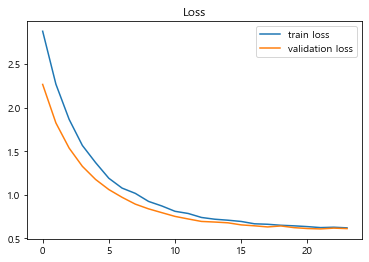

 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:20<00:35, 11.72s/it]

AUC 0.7350215331610681
DNN learning curve 8/10


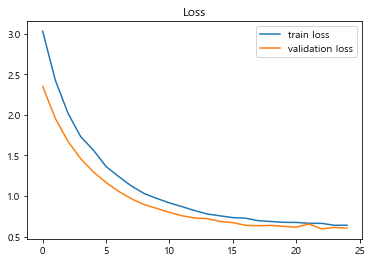

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:33<00:24, 12.13s/it]

AUC 0.7501928679693952
DNN learning curve 9/10


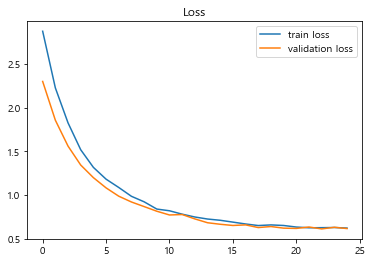

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:47<00:12, 12.87s/it]

AUC 0.7612814961301102
DNN learning curve 10/10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:01<00:00, 12.13s/it]

AUC 0.7488961437485082

Validation Summary:
3    0.794170
0    0.791650
1    0.789426
4    0.764481
8    0.761281
7    0.750193
9    0.748896
2    0.735655
6    0.735022
5    0.720957
dtype: float64
mean=0.75917, std=0.026


In [6]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)


    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.040)))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(12, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.55))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])  # adam,  , , , 
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=30, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)], verbose=0)


    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

In [10]:
N = 10
p = [2.56, 3.5, 4.5]
for j in p:
    # Power mean ensemble
    THRESHOLD = 0.77  # Use only models whose AUC exceeds this value

    pred = 0
    n = 0
    for i in range(N):
        if aucs.iloc[i] > THRESHOLD:
            pred = pred + preds[i]**j
            n += 1
    pred = pred / n    
    pred = pred**(1/j)

    # Make a submission file
    t = pd.Timestamp.now()
    fname = f"dae_p{j}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
    submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
    submissions.to_csv(fname, index=False)
    print(f"'{fname}' is ready to submit.")

'dae_p2.56n3_submit_06122314.csv' is ready to submit.
'dae_p3.5n3_submit_06122314.csv' is ready to submit.
'dae_p4.5n3_submit_06122314.csv' is ready to submit.
